In [1]:
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from lora_module import LoraTraining
from peft import LoraConfig, TaskType, get_peft_model
from remote_module import CustomConv1D
from torch.nn import Embedding
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Conv1D,
    DataCollatorForLanguageModeling,
    TextDataset,
    Trainer,
    TrainingArguments,
)

from concrete.ml.torch.hybrid_model import HybridFHEModel

SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [2]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

In [3]:
def generate_text(prompt, model, tokenizer, max_new_tokens=30):
    # Encode the input prompt
    inputs = tokenizer.encode_plus(prompt, return_tensors="pt")

    # Generate text
    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [4]:
# Example usage
prompt = "What is FHE ?"
generated_text = generate_text(prompt, model, tokenizer)
print(generated_text)

What is FHE? FH: A basic program that is used to calculate the height of an object, and then sets the minimum height to be the object's height.


In [5]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    fan_in_fan_out=True,
)

peft_model = get_peft_model(model, peft_config)

In [6]:
def replace_conv1d(module, module_index_to_skip=0):
    for name, child in module.named_children():
        if isinstance(child, Conv1D):

            # Skip the module if the index has not been reached, and decrement the index
            if module_index_to_skip >= 0:
                module_index_to_skip -= 1
            else:
                custom_linear = CustomConv1D(child.weight, bias=child.bias)
                setattr(module, name, custom_linear)
        else:
            module_index_to_skip = replace_conv1d(child, module_index_to_skip=module_index_to_skip)

    return module_index_to_skip


# Gradients of the first base layer that is used for fine-tuning are not needed. We
# therefore need to exclude the backward module from the remote_names since calibration
# won't get through it (which raises an issue with hybrid models)
replace_conv1d(peft_model, module_index_to_skip=0);

In [7]:
GRADIENT_ACCUMULATION_STEPS = 2

lora_training = LoraTraining(peft_model, GRADIENT_ACCUMULATION_STEPS)

In [8]:
BLOCK_SIZE = 128

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="data_finetune/what_is_fhe.txt",
    block_size=BLOCK_SIZE,
    cache_dir="cache_dataset",
)

In [9]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

EPOCHS = 100
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=5e-4,
    logging_strategy="epoch",
    optim="adamw_torch",
    seed=SEED,
    data_seed=SEED,
    weight_decay=0.0,
    warmup_steps=0,
    max_grad_norm=1.0,
)

In [10]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(trainer.optimizer, trainer.lr_scheduler, training_args)

In [11]:
def get_remote_names(model, include_embedding_layers=False):
    remote_names = []
    for name, module in model.named_modules():
        # Some gradients are not needed for fine-tuning, so need to exclude the backward module
        # from the remote_names since calibration won't get through it (which raises an issue with
        # hybrid models). We however still need to include the associated module's forward pass in
        # the hybrid model
        # We can also include the embedding and language model head as they represent a lot of the
        # model's parameters. Side note: "lm_head" does not appear in model.parameters() because
        # the weights are directly tied to the embedding ones, but we still need to remove both
        # modules in order to get rid of the weights
        if (
            isinstance(module, Conv1D)
            or include_embedding_layers
            and (isinstance(module, Embedding) or "lm_head" in name)
        ):
            remote_names.append(name)

        elif isinstance(module, CustomConv1D):
            remote_names.append(name + ".forward_module")
            remote_names.append(name + ".backward_module")

    return remote_names


# Do not include embedding layers as the model does not converge when quantizing them, even with
# 16 bits
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [12]:
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [13]:
input_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)
label_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)

inputset = (input_tensor, label_tensor)

In [14]:
hybrid_model.model.toggle_calibrate(enable=True)

hybrid_model.compile_model(inputset, n_bits=16)

hybrid_model.model.toggle_calibrate(enable=False)

In [15]:
def train_custom_model(hybrid_model, train_dataloader, training_args, fhe="disable"):
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    hybrid_model.model.inference_model.train()

    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        steps_in_epoch = len(train_dataloader)
        for step, batch in enumerate(train_dataloader):
            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            # Gradient accumulation
            is_last_batch_step = (
                steps_in_epoch <= training_args.gradient_accumulation_steps
                and (step + 1) == steps_in_epoch  # noqa: W503
            )
            accumulate_gradients = (
                total_batched_samples % training_args.gradient_accumulation_steps == 0
            )

            run_optimizer = is_last_batch_step or accumulate_gradients

            hybrid_model.model.toggle_run_optimizer(enable=run_optimizer)

            loss, grad_norm = hybrid_model((batch["input_ids"], batch["labels"]), fhe=fhe)

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = hybrid_model.model.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1]

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        hybrid_model.model.inference_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Progress:   1%|          | 1/100 [04:21<7:11:59, 261.81s/it]

Epoch 1/100, Loss: 1.5474, grad norm: 0.3355550169944763, lr: 0.000495


Training Progress:   2%|▏         | 2/100 [05:37<4:08:32, 152.17s/it]

Epoch 2/100, Loss: 1.5155, grad norm: 0.31825020909309387, lr: 0.00049


Training Progress:   3%|▎         | 3/100 [06:53<3:10:17, 117.70s/it]

Epoch 3/100, Loss: 1.5275, grad norm: 0.3436938226222992, lr: 0.00048499999999999997


Training Progress:   4%|▍         | 4/100 [08:11<2:42:54, 101.82s/it]

Epoch 4/100, Loss: 1.5121, grad norm: 0.4020688533782959, lr: 0.00048


Training Progress:   5%|▌         | 5/100 [09:29<2:27:34, 93.21s/it] 

Epoch 5/100, Loss: 1.4918, grad norm: 0.4025989770889282, lr: 0.000475


Training Progress:   6%|▌         | 6/100 [10:46<2:17:27, 87.73s/it]

Epoch 6/100, Loss: 1.4430, grad norm: 0.45770904421806335, lr: 0.00047


Training Progress:   7%|▋         | 7/100 [12:02<2:10:11, 84.00s/it]

Epoch 7/100, Loss: 1.4133, grad norm: 0.430878221988678, lr: 0.000465


Training Progress:   8%|▊         | 8/100 [13:19<2:05:08, 81.62s/it]

Epoch 8/100, Loss: 1.4292, grad norm: 0.41887837648391724, lr: 0.00046


Training Progress:   9%|▉         | 9/100 [14:36<2:01:38, 80.21s/it]

Epoch 9/100, Loss: 1.3899, grad norm: 0.4334312081336975, lr: 0.000455


Training Progress:  10%|█         | 10/100 [15:53<1:58:45, 79.18s/it]

Epoch 10/100, Loss: 1.3726, grad norm: 0.39489904046058655, lr: 0.00045000000000000004


Training Progress:  11%|█         | 11/100 [17:10<1:56:41, 78.67s/it]

Epoch 11/100, Loss: 1.3595, grad norm: 0.4469723701477051, lr: 0.00044500000000000003


Training Progress:  12%|█▏        | 12/100 [18:27<1:54:34, 78.12s/it]

Epoch 12/100, Loss: 1.3315, grad norm: 0.4357779920101166, lr: 0.00044


Training Progress:  13%|█▎        | 13/100 [19:46<1:53:25, 78.23s/it]

Epoch 13/100, Loss: 1.3278, grad norm: 0.43598729372024536, lr: 0.000435


Training Progress:  14%|█▍        | 14/100 [21:04<1:52:18, 78.35s/it]

Epoch 14/100, Loss: 1.2945, grad norm: 0.45333367586135864, lr: 0.00043


Training Progress:  15%|█▌        | 15/100 [22:25<1:52:00, 79.07s/it]

Epoch 15/100, Loss: 1.2902, grad norm: 0.6687149405479431, lr: 0.000425


Training Progress:  16%|█▌        | 16/100 [23:43<1:50:10, 78.70s/it]

Epoch 16/100, Loss: 1.2780, grad norm: 0.6073557138442993, lr: 0.00042


Training Progress:  17%|█▋        | 17/100 [25:01<1:48:45, 78.62s/it]

Epoch 17/100, Loss: 1.2283, grad norm: 0.4445655047893524, lr: 0.000415


Training Progress:  18%|█▊        | 18/100 [26:20<1:47:31, 78.68s/it]

Epoch 18/100, Loss: 1.2346, grad norm: 0.45586520433425903, lr: 0.00041


Training Progress:  19%|█▉        | 19/100 [27:40<1:46:32, 78.93s/it]

Epoch 19/100, Loss: 1.2004, grad norm: 0.5274876952171326, lr: 0.00040500000000000003


Training Progress:  20%|██        | 20/100 [28:58<1:44:54, 78.69s/it]

Epoch 20/100, Loss: 1.1746, grad norm: 0.4991244375705719, lr: 0.0004


Training Progress:  21%|██        | 21/100 [30:17<1:43:43, 78.78s/it]

Epoch 21/100, Loss: 1.1872, grad norm: 0.6167137622833252, lr: 0.000395


Training Progress:  22%|██▏       | 22/100 [31:34<1:41:51, 78.35s/it]

Epoch 22/100, Loss: 1.1244, grad norm: 0.4996899366378784, lr: 0.00039000000000000005


Training Progress:  23%|██▎       | 23/100 [32:52<1:40:17, 78.15s/it]

Epoch 23/100, Loss: 1.1141, grad norm: 0.5516778826713562, lr: 0.00038500000000000003


Training Progress:  24%|██▍       | 24/100 [34:10<1:38:58, 78.13s/it]

Epoch 24/100, Loss: 1.1002, grad norm: 0.602400541305542, lr: 0.00038


Training Progress:  25%|██▌       | 25/100 [35:27<1:37:18, 77.85s/it]

Epoch 25/100, Loss: 1.0972, grad norm: 0.550011932849884, lr: 0.000375


Training Progress:  26%|██▌       | 26/100 [36:46<1:36:37, 78.35s/it]

Epoch 26/100, Loss: 1.0889, grad norm: 0.6990661025047302, lr: 0.00037


Training Progress:  27%|██▋       | 27/100 [38:05<1:35:29, 78.49s/it]

Epoch 27/100, Loss: 1.0476, grad norm: 0.6277032494544983, lr: 0.000365


Training Progress:  28%|██▊       | 28/100 [39:27<1:35:25, 79.52s/it]

Epoch 28/100, Loss: 1.0656, grad norm: 0.6060994267463684, lr: 0.00035999999999999997


Training Progress:  29%|██▉       | 29/100 [40:50<1:35:06, 80.38s/it]

Epoch 29/100, Loss: 1.0325, grad norm: 0.6185253262519836, lr: 0.000355


Training Progress:  30%|███       | 30/100 [42:11<1:34:06, 80.67s/it]

Epoch 30/100, Loss: 1.0285, grad norm: 0.6253380179405212, lr: 0.00035


Training Progress:  31%|███       | 31/100 [43:33<1:33:06, 80.97s/it]

Epoch 31/100, Loss: 1.0221, grad norm: 0.7144878506660461, lr: 0.000345


Training Progress:  32%|███▏      | 32/100 [44:55<1:32:06, 81.27s/it]

Epoch 32/100, Loss: 0.9745, grad norm: 0.6706973314285278, lr: 0.00034


Training Progress:  33%|███▎      | 33/100 [46:14<1:30:10, 80.76s/it]

Epoch 33/100, Loss: 0.9694, grad norm: 0.6786661744117737, lr: 0.000335


Training Progress:  34%|███▍      | 34/100 [47:33<1:28:04, 80.07s/it]

Epoch 34/100, Loss: 0.9690, grad norm: 0.7508000731468201, lr: 0.00033


Training Progress:  35%|███▌      | 35/100 [48:53<1:26:41, 80.02s/it]

Epoch 35/100, Loss: 0.9460, grad norm: 0.7483748197555542, lr: 0.00032500000000000004


Training Progress:  36%|███▌      | 36/100 [50:13<1:25:34, 80.23s/it]

Epoch 36/100, Loss: 0.9379, grad norm: 0.6985185146331787, lr: 0.00032


Training Progress:  37%|███▋      | 37/100 [51:34<1:24:24, 80.38s/it]

Epoch 37/100, Loss: 0.9350, grad norm: 0.6791425943374634, lr: 0.000315


Training Progress:  38%|███▊      | 38/100 [52:53<1:22:45, 80.09s/it]

Epoch 38/100, Loss: 0.9112, grad norm: 0.7387422323226929, lr: 0.00031


Training Progress:  39%|███▉      | 39/100 [54:15<1:21:53, 80.55s/it]

Epoch 39/100, Loss: 0.9136, grad norm: 0.7416313290596008, lr: 0.000305


Training Progress:  40%|████      | 40/100 [55:36<1:20:35, 80.59s/it]

Epoch 40/100, Loss: 0.8848, grad norm: 0.7500932216644287, lr: 0.0003


Training Progress:  41%|████      | 41/100 [56:55<1:18:58, 80.32s/it]

Epoch 41/100, Loss: 0.8730, grad norm: 0.7485813498497009, lr: 0.000295


Training Progress:  42%|████▏     | 42/100 [58:18<1:18:15, 80.96s/it]

Epoch 42/100, Loss: 0.8654, grad norm: 0.8158472180366516, lr: 0.00029


Training Progress:  43%|████▎     | 43/100 [59:40<1:17:19, 81.40s/it]

Epoch 43/100, Loss: 0.8424, grad norm: 0.7175841331481934, lr: 0.000285


Training Progress:  44%|████▍     | 44/100 [1:01:00<1:15:33, 80.95s/it]

Epoch 44/100, Loss: 0.8444, grad norm: 0.7510058283805847, lr: 0.00028000000000000003


Training Progress:  45%|████▌     | 45/100 [1:02:22<1:14:28, 81.24s/it]

Epoch 45/100, Loss: 0.8358, grad norm: 0.8201435208320618, lr: 0.000275


Training Progress:  46%|████▌     | 46/100 [1:03:42<1:12:51, 80.96s/it]

Epoch 46/100, Loss: 0.8206, grad norm: 0.8101125955581665, lr: 0.00027


Training Progress:  47%|████▋     | 47/100 [1:05:04<1:11:47, 81.28s/it]

Epoch 47/100, Loss: 0.8212, grad norm: 0.857807993888855, lr: 0.00026500000000000004


Training Progress:  48%|████▊     | 48/100 [1:06:24<1:10:04, 80.86s/it]

Epoch 48/100, Loss: 0.8047, grad norm: 0.8056545853614807, lr: 0.00026000000000000003


Training Progress:  49%|████▉     | 49/100 [1:07:46<1:08:56, 81.11s/it]

Epoch 49/100, Loss: 0.8022, grad norm: 0.9604797959327698, lr: 0.000255


Training Progress:  50%|█████     | 50/100 [1:09:09<1:08:08, 81.78s/it]

Epoch 50/100, Loss: 0.7991, grad norm: 0.8402461409568787, lr: 0.00025


Training Progress:  51%|█████     | 51/100 [1:10:32<1:06:58, 82.01s/it]

Epoch 51/100, Loss: 0.7707, grad norm: 0.8492586016654968, lr: 0.000245


Training Progress:  52%|█████▏    | 52/100 [1:11:54<1:05:33, 81.96s/it]

Epoch 52/100, Loss: 0.7424, grad norm: 0.8156391382217407, lr: 0.00024


Training Progress:  53%|█████▎    | 53/100 [1:13:15<1:04:07, 81.85s/it]

Epoch 53/100, Loss: 0.7495, grad norm: 0.8408838510513306, lr: 0.000235


Training Progress:  54%|█████▍    | 54/100 [1:14:38<1:02:49, 81.95s/it]

Epoch 54/100, Loss: 0.7483, grad norm: 0.8604503273963928, lr: 0.00023


Training Progress:  55%|█████▌    | 55/100 [1:15:59<1:01:19, 81.76s/it]

Epoch 55/100, Loss: 0.7442, grad norm: 0.8854144811630249, lr: 0.00022500000000000002


Training Progress:  56%|█████▌    | 56/100 [1:17:22<1:00:18, 82.24s/it]

Epoch 56/100, Loss: 0.7407, grad norm: 0.8788455724716187, lr: 0.00022


Training Progress:  57%|█████▋    | 57/100 [1:18:42<58:30, 81.65s/it]  

Epoch 57/100, Loss: 0.7387, grad norm: 0.8970968723297119, lr: 0.000215


Training Progress:  58%|█████▊    | 58/100 [1:20:05<57:19, 81.89s/it]

Epoch 58/100, Loss: 0.7260, grad norm: 0.8925109505653381, lr: 0.00021


Training Progress:  59%|█████▉    | 59/100 [1:21:26<55:53, 81.78s/it]

Epoch 59/100, Loss: 0.6772, grad norm: 0.9218511581420898, lr: 0.000205


Training Progress:  60%|██████    | 60/100 [1:22:50<54:55, 82.39s/it]

Epoch 60/100, Loss: 0.6988, grad norm: 0.9442291259765625, lr: 0.0002


Training Progress:  61%|██████    | 61/100 [1:24:14<53:54, 82.95s/it]

Epoch 61/100, Loss: 0.7092, grad norm: 0.9974638223648071, lr: 0.00019500000000000002


Training Progress:  62%|██████▏   | 62/100 [1:25:50<54:52, 86.65s/it]

Epoch 62/100, Loss: 0.6930, grad norm: 1.0726863145828247, lr: 0.00019


Training Progress:  63%|██████▎   | 63/100 [1:27:22<54:24, 88.23s/it]

Epoch 63/100, Loss: 0.6756, grad norm: 1.0581772327423096, lr: 0.000185


Training Progress:  64%|██████▍   | 64/100 [1:28:42<51:26, 85.74s/it]

Epoch 64/100, Loss: 0.6719, grad norm: 0.9272902607917786, lr: 0.00017999999999999998


Training Progress:  65%|██████▌   | 65/100 [1:30:01<48:52, 83.78s/it]

Epoch 65/100, Loss: 0.6711, grad norm: 1.0115615129470825, lr: 0.000175


Training Progress:  66%|██████▌   | 66/100 [1:31:20<46:39, 82.33s/it]

Epoch 66/100, Loss: 0.6454, grad norm: 1.0066094398498535, lr: 0.00017


Training Progress:  67%|██████▋   | 67/100 [1:32:39<44:45, 81.38s/it]

Epoch 67/100, Loss: 0.6618, grad norm: 1.120772123336792, lr: 0.000165


Training Progress:  68%|██████▊   | 68/100 [1:33:58<43:00, 80.64s/it]

Epoch 68/100, Loss: 0.6186, grad norm: 0.9725711941719055, lr: 0.00016


Training Progress:  69%|██████▉   | 69/100 [1:35:17<41:27, 80.23s/it]

Epoch 69/100, Loss: 0.6370, grad norm: 1.082191824913025, lr: 0.000155


Training Progress:  70%|███████   | 70/100 [1:36:36<39:55, 79.86s/it]

Epoch 70/100, Loss: 0.6318, grad norm: 0.9971476197242737, lr: 0.00015


Training Progress:  71%|███████   | 71/100 [1:37:55<38:26, 79.53s/it]

Epoch 71/100, Loss: 0.6331, grad norm: 0.963691771030426, lr: 0.000145


Training Progress:  72%|███████▏  | 72/100 [1:39:15<37:11, 79.71s/it]

Epoch 72/100, Loss: 0.6309, grad norm: 1.3207135200500488, lr: 0.00014000000000000001


Training Progress:  73%|███████▎  | 73/100 [1:40:35<35:54, 79.79s/it]

Epoch 73/100, Loss: 0.6136, grad norm: 1.0440832376480103, lr: 0.000135


Training Progress:  74%|███████▍  | 74/100 [1:41:56<34:43, 80.13s/it]

Epoch 74/100, Loss: 0.6104, grad norm: 0.9647199511528015, lr: 0.00013000000000000002


Training Progress:  75%|███████▌  | 75/100 [1:43:17<33:27, 80.28s/it]

Epoch 75/100, Loss: 0.5994, grad norm: 1.0407522916793823, lr: 0.000125


Training Progress:  76%|███████▌  | 76/100 [1:44:37<32:04, 80.19s/it]

Epoch 76/100, Loss: 0.6159, grad norm: 1.2311997413635254, lr: 0.00012


Training Progress:  77%|███████▋  | 77/100 [1:45:56<30:37, 79.87s/it]

Epoch 77/100, Loss: 0.5741, grad norm: 1.0105656385421753, lr: 0.000115


Training Progress:  78%|███████▊  | 78/100 [1:47:15<29:11, 79.62s/it]

Epoch 78/100, Loss: 0.5841, grad norm: 1.1994893550872803, lr: 0.00011


Training Progress:  79%|███████▉  | 79/100 [1:48:34<27:51, 79.60s/it]

Epoch 79/100, Loss: 0.6114, grad norm: 1.0626143217086792, lr: 0.000105


Training Progress:  80%|████████  | 80/100 [1:49:54<26:35, 79.76s/it]

Epoch 80/100, Loss: 0.5880, grad norm: 1.054750919342041, lr: 0.0001


Training Progress:  81%|████████  | 81/100 [1:51:14<25:16, 79.84s/it]

Epoch 81/100, Loss: 0.5655, grad norm: 0.9550267457962036, lr: 9.5e-05


Training Progress:  82%|████████▏ | 82/100 [1:52:35<24:03, 80.21s/it]

Epoch 82/100, Loss: 0.5946, grad norm: 1.1578212976455688, lr: 8.999999999999999e-05


Training Progress:  83%|████████▎ | 83/100 [1:53:55<22:41, 80.08s/it]

Epoch 83/100, Loss: 0.6003, grad norm: 1.075507640838623, lr: 8.5e-05


Training Progress:  84%|████████▍ | 84/100 [1:55:15<21:21, 80.10s/it]

Epoch 84/100, Loss: 0.5775, grad norm: 1.0394887924194336, lr: 8e-05


Training Progress:  85%|████████▌ | 85/100 [1:56:34<19:56, 79.77s/it]

Epoch 85/100, Loss: 0.5864, grad norm: 1.0302282571792603, lr: 7.5e-05


Training Progress:  86%|████████▌ | 86/100 [1:57:54<18:34, 79.60s/it]

Epoch 86/100, Loss: 0.5628, grad norm: 1.1795330047607422, lr: 7.000000000000001e-05


Training Progress:  87%|████████▋ | 87/100 [1:59:13<17:14, 79.55s/it]

Epoch 87/100, Loss: 0.5564, grad norm: 1.086024284362793, lr: 6.500000000000001e-05


Training Progress:  88%|████████▊ | 88/100 [2:00:33<15:56, 79.73s/it]

Epoch 88/100, Loss: 0.5744, grad norm: 1.257170557975769, lr: 6e-05


Training Progress:  89%|████████▉ | 89/100 [2:01:52<14:34, 79.53s/it]

Epoch 89/100, Loss: 0.5486, grad norm: 1.1120915412902832, lr: 5.5e-05


Training Progress:  90%|█████████ | 90/100 [2:03:12<13:15, 79.51s/it]

Epoch 90/100, Loss: 0.5657, grad norm: 1.0620477199554443, lr: 5e-05


Training Progress:  91%|█████████ | 91/100 [2:04:32<11:57, 79.78s/it]

Epoch 91/100, Loss: 0.5395, grad norm: 1.2674777507781982, lr: 4.4999999999999996e-05


Training Progress:  92%|█████████▏| 92/100 [2:05:52<10:39, 79.96s/it]

Epoch 92/100, Loss: 0.5680, grad norm: 1.1475542783737183, lr: 4e-05


Training Progress:  93%|█████████▎| 93/100 [2:07:13<09:21, 80.23s/it]

Epoch 93/100, Loss: 0.5806, grad norm: 1.1923059225082397, lr: 3.5000000000000004e-05


Training Progress:  94%|█████████▍| 94/100 [2:08:44<08:20, 83.37s/it]

Epoch 94/100, Loss: 0.5429, grad norm: 0.9368011951446533, lr: 3e-05


Training Progress:  95%|█████████▌| 95/100 [2:10:20<07:15, 87.17s/it]

Epoch 95/100, Loss: 0.5607, grad norm: 1.0647990703582764, lr: 2.5e-05


Training Progress:  96%|█████████▌| 96/100 [2:11:46<05:46, 86.74s/it]

Epoch 96/100, Loss: 0.5430, grad norm: 1.1920421123504639, lr: 2e-05


Training Progress:  97%|█████████▋| 97/100 [2:13:05<04:13, 84.58s/it]

Epoch 97/100, Loss: 0.5526, grad norm: 0.9896294474601746, lr: 1.5e-05


Training Progress:  98%|█████████▊| 98/100 [2:14:25<02:46, 83.18s/it]

Epoch 98/100, Loss: 0.5591, grad norm: 1.126670241355896, lr: 1e-05


Training Progress:  99%|█████████▉| 99/100 [2:15:45<01:22, 82.11s/it]

Epoch 99/100, Loss: 0.5530, grad norm: 1.1123902797698975, lr: 5e-06


Training Progress: 100%|██████████| 100/100 [2:17:06<00:00, 81.94s/it]

Epoch 100/100, Loss: 0.5362, grad norm: 1.0141682624816895, lr: 0.0


Training Progress: 100%|██████████| 100/100 [2:17:07<00:00, 82.28s/it]


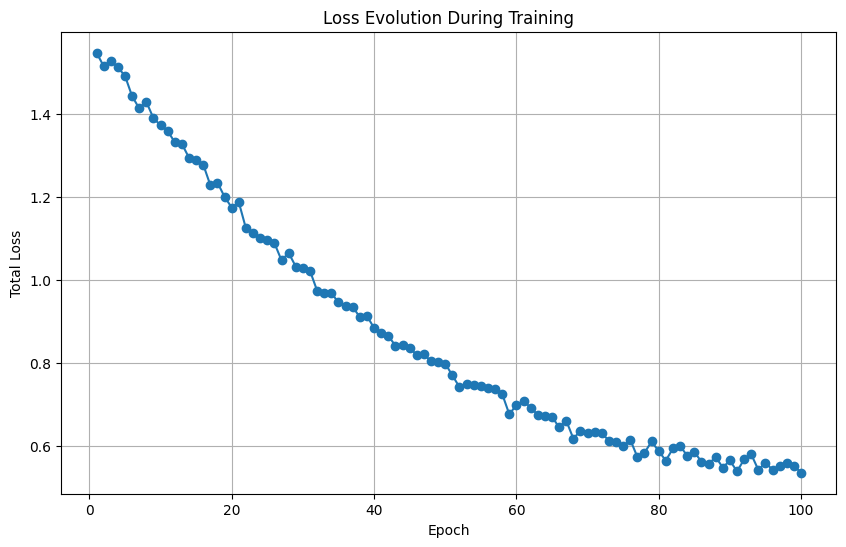

In [16]:
# Avoid the following error from HuggingFace when training :
# "The current process just got forked, after parallelism has already been used. Disabling
# parallelism to avoid deadlocks..."
tokenizer.parallelism = False

train_custom_model(hybrid_model, train_dataloader, training_args, fhe="simulate")

In [17]:
fine_tuned_model = hybrid_model.model.inference_model

# In simulation, we can only generate a single token at a time because of fixed size circuits
# and how `generate` works (only the last token from the previous generation is kept)
hybrid_model.set_fhe_mode("disable")

In [18]:
prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE?

FHE? FHS is a groundbreaking concept that allows the use of cloud computing to help protect data and privacy while still allowing data to be


In [19]:
peft_model.disable_adapter_layers()

prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

peft_model.enable_adapter_layers()

What is FHE?

FHE is a new form of the term "fission energy". It is the energy of fusion of a process which is in a state


In [20]:
def print_weights_and_size(model, print_detail=False):
    total_weights = 0
    total_lora_weights = 0
    for name, param in model.named_parameters():
        total_weights += param.numel()

        if "lora" in name:
            total_lora_weights += param.numel()

        if print_detail:
            print(name, param.numel())

    print(f"Total number of weights: {total_weights}")
    print(f"Total number of LoRA weights: {total_lora_weights}")

    return total_weights

In [21]:
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124587264
Total number of LoRA weights: 147456


In [22]:
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [23]:
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39569664
Total number of LoRA weights: 147456


In [24]:
print(
    "Total weights removed: "
    f"{(total_weights_size - total_weights_size_private) / total_weights_size * 100:.2f} %"
)

Total weights removed: 68.24 %


Around 95% of the remaining weights are from the embedding layers (wpe and wte) as well as the final lm_head layer.